In [ ]:
# default_exp clone_counters

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# export
import re
from functools import partial, reduce
from glob import glob
from typing import Callable

import dask.array as da
import dask.dataframe as dd
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from skimage import measure

from py_clone_detective import clone_analysis as ca
from py_clone_detective.utils import (
    add_scale_regionprops_table_area_measurements,
    calculate_corresponding_labels,
    calculate_overlap,
    check_channels_input_suitable_and_return_channels,
    determine_labels_across_other_images_using_centroids,
    extend_region_properties_list,
    get_all_labeled_clones_unmerged_and_merged,
    img_path_to_xarr,
    last2dims,
    lazy_props,
    plot_threshold_imgs_side_by_side,
    reorder_df_to_put_ch_info_first,
    update_1st_coord_and_dim_of_xarr,
)

# CloneCounter Classes

## Parent Class

In [ ]:
# export
class CloneCounter:
    def __init__(
        self,
        exp_name: str,
        img_name_regex: str,
        pixel_size: float,
        tot_seg_ch: str = "C0",
    ):
        self.exp_name = exp_name
        self.img_name_regex = img_name_regex
        self.pixel_size = pixel_size
        self.tot_seg_ch = tot_seg_ch

    def add_images(self, **channel_path_globs):
        return img_path_to_xarr(
            self.img_name_regex,
            self.pixel_size,
            ch_name_for_first_dim="img_channels",
            **channel_path_globs,
        )

    def add_segmentations(
        self,
        additional_func_to_map: Callable = None,
        ad_func_kwargs: dict = None,
        **channel_path_globs,
    ):
        segmentations = img_path_to_xarr(
            self.img_name_regex,
            self.pixel_size,
            ch_name_for_first_dim="seg_channels",
            **channel_path_globs,
        )

        if additional_func_to_map is not None:
            segmentations.data = segmentations.data.map_blocks(
                additional_func_to_map, **ad_func_kwargs, dtype=np.uint16
            )

        segmentations.data = segmentations.data.map_blocks(
            last2dims(partial(measure.label)), dtype=np.uint16
        )
        return segmentations

    def combine_C0_overlaps_and_measurements(self):
        ov_df = (
            self.results_overlaps.pivot(
                index=["img_name", "C0_labels"],
                columns=["colocalisation_ch"],
                values="is_in_label",
            )
            .query("C0_labels != 0")
            .copy()
        )
        sk_df = self.results_measurements.query("seg_ch== 'C0'").set_index(
            ["seg_img", "label"]
        )
        sk_df.index.rename(["img_name", "C0_labels"], inplace=True)
        return pd.merge(ov_df, sk_df, left_index=True, right_index=True)

    def determine_seg_img_channel_pairs(
        self, seg_channels: list = None, img_channels: list = None
    ):
        seg_channels = check_channels_input_suitable_and_return_channels(
            channels=seg_channels,
            available_channels=self.image_data.seg_channels.values.tolist(),
        )

        img_channels = check_channels_input_suitable_and_return_channels(
            channels=img_channels,
            available_channels=self.image_data.img_channels.values.tolist(),
        )

        seg_img_channel_pairs = pd.DataFrame()
        seg_img_channel_pairs["image_channel"] = pd.Series(img_channels)
        seg_img_channel_pairs["segmentation_channel"] = pd.Series(seg_channels)
        self.seg_img_channel_pairs = seg_img_channel_pairs.fillna(method="ffill")[
            ["segmentation_channel", "image_channel"]
        ]

    def make_measurements(
        self,
        seg_channels: list = None,
        img_channels: list = None,
        extra_properties: list = None,
        **kwargs,
    ):

        self.determine_seg_img_channel_pairs(seg_channels, img_channels)

        properties = extend_region_properties_list(extra_properties)

        results = list()
        for _, seg_ch, img_ch in self.seg_img_channel_pairs.itertuples():
            for seg, img in zip(
                self.image_data["segmentations"].loc[seg_ch],
                self.image_data["images"].loc[img_ch],
            ):
                results.append(
                    lazy_props(
                        seg.data,
                        img.data,
                        seg.seg_channels.item(),
                        img.img_channels.item(),
                        seg.img_name.item(),
                        img.img_name.item(),
                        properties,
                        **kwargs,
                    )
                )

        df = dd.from_delayed(results).compute()
        df = add_scale_regionprops_table_area_measurements(df, self.pixel_size)
        self.results_measurements = reorder_df_to_put_ch_info_first(df)
        self._determine_max_seg_label_levels()

    def _determine_max_seg_label_levels(self):
        self.tot_seg_ch_max_labels = (
            self.image_data["segmentations"]
            .loc[self.tot_seg_ch]
            .data.map_blocks(
                lambda x: np.unique(x).shape[0], drop_axis=(1, 2), dtype=np.uint16,
            )
            .compute()
            .max()
        )

    def _create_df_from_arr(self, arr):
        return (
            xr.DataArray(
                np.moveaxis(arr, 1, 0),
                coords=(
                    self.image_data["segmentations"].coords["seg_channels"][1:],
                    self.image_data["segmentations"].coords["img_name"],
                    np.arange(self.tot_seg_ch_max_labels),
                ),
                dims=("colocalisation_ch", "img_name", "C0_labels",),
            )
            .to_dataframe("is_in_label")
            .reset_index()
            .dropna()
        )

    def measure_overlap(self):
        self._determine_max_seg_label_levels()
        arr = (
            self.image_data["segmentations"]
            .data.map_blocks(
                calculate_overlap,
                drop_axis=[0],
                dtype=np.float64,
                num_of_segs=self.image_data["segmentations"].shape[0],
                preallocate_value=self.tot_seg_ch_max_labels,
            )
            .compute()
        )

        df = self._create_df_from_arr(arr)
        df["is_in_label"] = df["is_in_label"].astype(np.uint16)
        self.results_overlaps = df[
            ["img_name", "C0_labels", "colocalisation_ch", "is_in_label"]
        ]

    def testing_possible_thresholds(
        self,
        int_img: str,
        int_img_ch: str,
        seg_img_ch: str,
        threshold_list: list,
        threshold_constant: int = None,
        threshold_query: str = "mean_intensity > threshold_list & eccentricity > threshold_constant",
    ):
        img = (
            self.image_data["images"]
            .sel(img_channels=int_img_ch, img_name=int_img)
            .compute()
        ).data

        seg = (
            self.image_data["segmentations"]
            .sel(seg_channels=seg_img_ch, img_name=int_img)
            .compute()
        ).data

        df = self.results_measurements.query(
            "int_img == @int_img & int_img_ch == @int_img_ch & seg_ch == @seg_img_ch"
        )

        if threshold_constant is not None:
            threshold_query = re.sub(
                "threshold_constant", str(threshold_constant), threshold_query
            )

        thresh_img_dict = dict()
        for value in threshold_list:
            specific_query = re.sub("threshold_list", str(value), threshold_query)
            to_keep = df.query(specific_query)["label"].values
            thresh_img_dict[specific_query] = np.isin(seg, to_keep)

        plot_threshold_imgs_side_by_side(img, thresh_img_dict)

    def filter_labels_update_measurements_df_and_to_dict(
        self, query_for_pd: str, name_for_query: str
    ):

        self.results_measurements[
            f"{name_for_query}_pos"
        ] = self.results_measurements.eval(query_for_pd)

        temp_df = self.results_measurements.groupby(["int_img", "label"])[
            f"{name_for_query}_pos"
        ].any()

        self.results_measurements = pd.merge(
            self.results_measurements.drop(columns=[f"{name_for_query}_pos"]),
            temp_df,
            on=["int_img", "label"],
        )

        return (
            self.results_measurements.query(query_for_pd)
            .groupby("int_img")
            .agg({"label": lambda x: list(x)})["label"]
            .to_dict()
        )

    def get_centroids_list(self):
        df = self.results_measurements.query("int_img_ch == @self.tot_seg_ch")
        centroids_list = list()
        for img_name in df["int_img"].unique():
            centroids_list.append(
                (
                    df.query("int_img == @img_name")
                    .loc[:, ["centroid-0", "centroid-1"]]
                    .values.astype(int)
                )
            )
        return centroids_list

    def add_clones_and_neighbouring_labels(
        self,
        query_for_pd: str = 'int_img_ch == "C1" & mean_intensity > 1000',
        name_for_query: str = "C1",
        calc_clones: bool = True,
    ):
        new_coord = [
            "extended_tot_seg_labels",
            f"{name_for_query}_pos_labels",
            f"{name_for_query}_neg_labels",
            "total_neighbour_counts",
            f"{name_for_query}pos_neigh_counts",
            f"{name_for_query}neg_neigh_counts",
        ]

        if calc_clones:
            new_coord.append(f"{name_for_query}_clone")

        clone_coords, clone_dims = update_1st_coord_and_dim_of_xarr(
            self.image_data["images"],
            new_coord=new_coord,
            new_dim=f"{name_for_query}_neighbours",
        )

        labels_to_keep = self.filter_labels_update_measurements_df_and_to_dict(
            query_for_pd, name_for_query
        )

        new_label_imgs = get_all_labeled_clones_unmerged_and_merged(
            self.image_data["segmentations"].loc[self.tot_seg_ch],
            labels_to_keep,
            calc_clones,
        )

        return xr.DataArray(
            data=new_label_imgs,
            coords=clone_coords,
            dims=clone_dims,
            attrs={f"{self.tot_seg_ch}_labels_kept_query": query_for_pd},
        )

    def colabels_to_df(self, colabels, name_for_query):
        return (
            xr.DataArray(
                colabels,
                coords=(
                    self.image_data[name_for_query].coords[
                        f"{name_for_query}_neighbours"
                    ],
                    self.image_data[name_for_query].coords["img_name"],
                    range(1, colabels.shape[2] + 1),
                ),
                dims=(f"{name_for_query}_neighbours", "img_name", "label"),
            )
            .to_dataframe("colabel")
            .reset_index()
            .dropna()
            .pivot(
                index=["img_name", "label"],
                columns=[f"{name_for_query}_neighbours"],
                values="colabel",
            )
            .astype(np.uint16)
            .query("label == extended_tot_seg_labels")
        )

    def measure_clones_and_neighbouring_labels(self, name_for_query):
        self.get_centroids_list()
        colabels = calculate_corresponding_labels(
            self.image_data[name_for_query].data,
            self.get_centroids_list(),
            self.image_data[name_for_query].shape[0],
            self.tot_seg_ch_max_labels,
        )

        if not hasattr(self, "results_clones_and_neighbour_counts"):
            self.results_clones_and_neighbour_counts = dict()

        self.results_clones_and_neighbour_counts[name_for_query] = self.colabels_to_df(
            colabels, name_for_query
        )

        self.results_clones_and_neighbour_counts[name_for_query].index.rename(
            ["int_img", "label"], inplace=True
        )

    def combine_neighbour_counts_and_measurements(self):
        list_df = list(self.results_clones_and_neighbour_counts.values()) + [
            self.results_measurements.set_index(["int_img", "label"])
        ]
        merged_df = reduce(
            lambda left, right: pd.merge(
                left,
                right,
                how="left",
                on=["int_img", "label"],
                suffixes=(None, "_extra"),
            ),
            list_df,
        )

        cols_to_drop = merged_df.filter(regex="_labels|extra").columns.tolist() + [
            "extended_tot_seg_labels"
        ]

        return merged_df.drop(columns=cols_to_drop)

## CloneCounter subclasses

In [ ]:
# export
class LazyCloneCounter(CloneCounter):
    def __init__(
        self,
        exp_name: str,
        img_name_regex: str,
        pixel_size: float,
        tot_seg_ch: str = "C0",
    ):
        super().__init__(exp_name, img_name_regex, pixel_size)

    def add_images(self, **channel_path_globs):
        self.image_data = xr.Dataset(
            {"images": super().add_images(**channel_path_globs)}
        )

    def add_segmentations(
        self,
        additional_func_to_map: Callable = None,
        ad_func_kwargs: dict = None,
        **channel_path_globs
    ):
        self.image_data["segmentations"] = super().add_segmentations(
            additional_func_to_map, ad_func_kwargs, **channel_path_globs
        )

    def add_clones_and_neighbouring_labels(
        self,
        query_for_pd: str = 'int_img_ch == "C1" & mean_intensity > 1000',
        name_for_query: str = "filt_C1_intensity",
        calc_clones: bool = True,
    ):
        self.image_data[name_for_query] = super().add_clones_and_neighbouring_labels(
            query_for_pd, name_for_query, calc_clones
        )

In [ ]:
# export
class PersistentCloneCounter(CloneCounter):
    def __init__(
        self,
        exp_name: str,
        img_name_regex: str,
        pixel_size: float,
        tot_seg_ch: str = "C0",
    ):
        super().__init__(exp_name, img_name_regex, pixel_size)

    def add_images(self, **channel_path_globs):
        self.image_data = xr.Dataset(
            {"images": super().add_images(**channel_path_globs)}
        ).persist()

    def add_segmentations(
        self,
        additional_func_to_map: Callable = None,
        ad_func_kwargs: dict = None,
        **channel_path_globs,
    ):
        self.image_data["segmentations"] = (
            super()
            .add_segmentations(
                additional_func_to_map, ad_func_kwargs, **channel_path_globs
            )
            .persist()
        )

    def add_clones_and_neighbouring_labels(
        self,
        query_for_pd: str = 'int_img_ch == "C1" & mean_intensity > 1000',
        name_for_query: str = "filt_C1_intensity",
        calc_clones: bool = True,
    ):
        self.image_data[name_for_query] = (
            super()
            .add_clones_and_neighbouring_labels(
                query_for_pd, name_for_query, calc_clones
            )
            .persist()
        )

In [ ]:
# hide
from dask.distributed import Client

c = Client()
c

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:52340,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:52349,Total threads: 2
Dashboard: http://127.0.0.1:52350/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:52343,


## Example using LazyCloneCounter with measure_overlap

In [ ]:
bar = LazyCloneCounter("Marcm2a_E7F1", r"a\dg\d\dp\d", 0.275)

bar.add_images(
    C0="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C0/C0_imgs/*.tif*",
    C1="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C1/C1_imgs/*.tif*",
    C2="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C2/C2_imgs/*.tif*",
    C3="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C3/C3_imgs/*.tif*",
)

bar.add_segmentations(
    C0="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C0/C0_label_imgs_combined_C3/*.tif*",
    C1="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C1/C1_binaries/*.tif*",
    C2="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C2/C2_label_imgs_v2/*.tif*",
    C3="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C3/C3_label_imgs/*.tif*",
)
bar.make_measurements(extra_properties=["convex_area"],)
df = bar.measure_overlap()
# df = bar.combine_C0_overlaps_and_measurements()

In [ ]:
ca.query_df_groupby_by_clone_channel(
    df,
    {
        "C2negC3neg_C0area_less_than_50um2": "C3 == 0 & C2 == 0 & area_um2 < 50",
        "C2negC3neg_C0area_greater_than_50um2": "C3 == 0 & C2 == 0 & area_um2 > 50",
        "C2pos": "C2 != 0",
        "C3pos": "C3 != 0",
    },
    clone_channel="C1",
)

## Example using LazyCloneCounter with add_clones_and_neighbouring_labels

In [ ]:
from skimage import morphology

In [ ]:
foo = LazyCloneCounter("Marcm2a_E7F1", r"a\dg\d\dp\d", 0.275)

foo.add_images(
    C0="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C0/C0_imgs/*.tif*",
    C1="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C1/C1_imgs/*.tif*",
    C2="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C2/C2_imgs/*.tif*",
    C3="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C3/C3_imgs/*.tif*",
)

foo.add_segmentations(
    morphology.remove_small_objects,
    ad_func_kwargs={"min_size": 49},
    C0="../current_imaging_analysis/MARCM2A_E7F1_refactoring/C0/C0_label_imgs_combined_C3/*.tif*",
)

foo.make_measurements()

In [ ]:
foo.add_clones_and_neighbouring_labels(
    query_for_pd='int_img_ch == "C1" & mean_intensity > 1000',
    name_for_query="C1",
    calc_clones=True,
)

In [ ]:
foo.results_measurements = foo.results_measurements.eval(
    "total_intensity = mean_intensity * area"
)

In [ ]:
foo.add_clones_and_neighbouring_labels(
    query_for_pd='int_img_ch == "C2" & total_intensity > 5e5',
    name_for_query="C2",
    calc_clones=False,
)

In [ ]:
foo.add_clones_and_neighbouring_labels(
    query_for_pd='int_img_ch == "C3" & mean_intensity > 1000',
    name_for_query="C3",
    calc_clones=False,
)

In [ ]:
foo.measure_clones_and_neighbouring_labels(name_for_query="C1")

In [ ]:
foo.measure_clones_and_neighbouring_labels(name_for_query="C2")

In [ ]:
foo.measure_clones_and_neighbouring_labels(name_for_query="C3")

In [ ]:
df = foo.combine_neighbour_counts_and_measurements()

In [ ]:
df

C1_clone  C1neg_neigh_counts  C1pos_neigh_counts  \
int_img label                                                     
a1g01p1 12            0                   2                   1   
        12            0                   2                   1   
        12            0                   2                   1   
        12            0                   2                   1   
        13            0                   3                   0   
...                 ...                 ...                 ...   
a2g13p3 232           0                   3                   0   
        233           0                   2                   0   
        233           0                   2                   0   
        233           0                   2                   0   
        233           0                   2                   0   

               total_neighbour_counts  C2neg_neigh_counts  C2pos_neigh_counts  \
int_img label                                                                   
a1g01p1 12                          3                   0                   3   
        12                          3                   0                   3   
        12                          3                   0                   3   
        12                          3                   0                   3   
        13                          3                   1                   2   
...                               ...                 ...                 ...   
a2g13p3 232                         3                   2                   1   
        233                         2                   1                   1   
        233                         2                   1                   1   
        233                         2                   1                   1   
        233                         2                   1                   1   

               C3neg_neigh_counts  C3pos_neigh_counts seg_ch int_img_ch  \
int_img label                                                             
a1g01p1 12                      3                   0     C0         C0   
        12                      3                   0     C0         C1   
        12                      3                   0     C0         C2   
        12                      3                   0     C0         C3   
        13                      3                   0     C0         C0   
...                           ...                 ...    ...        ...   
a2g13p3 232                     3                   0     C0         C3   
        233                     2                   0     C0         C0   
        233                     2                   0     C0         C1   
        233                     2                   0     C0         C2   
        233                     2                   0     C0         C3   

               seg_img  area  mean_intensity  centroid-0  centroid-1  \
int_img label                                                          
a1g01p1 12     a1g01p1  1094     2103.588665   43.901280   89.606947   
        12     a1g01p1  1094       60.372029   43.901280   89.606947   
        12     a1g01p1  1094     2209.449726   43.901280   89.606947   
        12     a1g01p1  1094       73.462523   43.901280   89.606947   
        13     a1g01p1  1123     3414.680321   51.479964  362.270703   
...                ...   ...             ...         ...         ...   
a2g13p3 232    a2g13p3   723      107.864454  772.175657  475.138313   
        233    a2g13p3   253     1257.762846  771.916996  675.988142   
        233    a2g13p3   253       32.418972  771.916996  675.988142   
        233    a2g13p3   253      742.395257  771.916996  675.988142   
        233    a2g13p3   253       99.430830  771.916996  675.988142   

                area_um2  C1_pos  total_intensity  C2_pos  C3_pos  
int_img label                                                      
a1g01p1 12     82.733750   False        

In [ ]:
bar = ca.query_df_groupby_by_clone_channel(
    df.query('int_img_ch == "C1"').reset_index(),
    queries={
        #         "Total": None,
        "C2negC3neg_C0area_less_than_50um2": "C2_pos == False & C3_pos == False & area_um2 < 50",
        "C2negC3neg_C0area_greater_than_50um2": "C2_pos == False & C3_pos == False & area_um2 > 50",
        "C2pos_count": "C2_pos == True",
        "C3_pos_count": "C3_pos == True",
    },
    clone_channel="C1_clone",
).reset_index()

In [ ]:
from py_clone_detective.clone_analysis import create_stack_bar_plot

In [ ]:
bar[["genotype"]] = bar["int_img"].str.extract(r"(a\d)")

In [ ]:
temp = (
    bar[bar.C1_clone > 0]
    .set_index("genotype")
    .loc[:, (slice(None), "label", "count")]
    .fillna(0)
    .groupby("genotype")
    .mean()
)

In [ ]:
temp_sem = (
    bar[bar.C1_clone > 0]
    .set_index("genotype")
    .loc[:, (slice(None), "label", "count")]
    .fillna(0)
    .groupby("genotype")
    .sem()
)

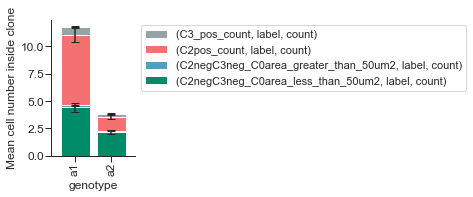

In [ ]:
create_stack_bar_plot(
    temp,
    temp_sem,
    x_figSize=1.5,
    y_figSize=2.5,
    y_label=f"Mean cell number inside clone",
    color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6"],
    bar_width=0.8,
)